# PHYS 381 - Assignment #5 
#### March 18, 2018
John Ming Ngo (30020834)

Kenneth Barry Sharman (00300185)

### Introduction
We continue our study of differential equations using numerical methods with the analysis of a driven harmonic oscillator. The task at hand is to analyze the phenomenon  of resonance, by plotting amplitude versus driving frequency $\omega$ for a range of damping ratios, $\zeta$.

Recall from Classical Mechanics that Newtons Second Law takes the form:

$$m\dfrac{d^2x}{dt^2}=F_H+F_{damp}+F_{dr}$$

$F_{damp}$ is the damping force.

$F_H$ is a Hooke's law restoring force

$F_{dr}$ is a driving force. Assume it has the form, $F_{dr}=F_0 \cos(\omega t)$


Replacing the forces with their dependences on $x$ and $\dot{x}$ and dividing my $m$ leads to:

$$\ddot{x}+2\gamma \dot{x}+\omega_0^2=f_0cos(\omega t)$$

where $f_0=F_0/m$, $\omega_0$ is the natural frequency, and $\gamma=\zeta\omega_0$. If we let $m=\omega_0=1$ then $\gamma=\zeta$ and the analysis of this system is greatly simplified.

It can be shown that the complete solution is:

$$x(t)=x_h(t)+x_p(t)=A_{trans}e^{-\gamma t}cos(\omega_1 t + \theta) + A_{steady} \cos{\omega t - \varphi}$$

$$A_{steady}=\dfrac{F_0/m}{((\omega_0^2-\omega^2)^2+4\gamma^2\omega^2)^{1/2}}$$

From the second last equation we can see that for large times, the transient motion will die off and the motion of the oscillator will be independent of the initial conditions.

The goal is to plot the late-time amplitudes as a function of the driving force, utilizing computational methods. To do so, we must first determine at what time the transient motion has decayed such that we can approximate the displacement to have reached its steady-state. In order to get the trajectory of the harmonic spring system over time, we will note that the spring system is dependent on its position and its velocity. The derivatives of these values are the velocity and acceleration, respectively. We can utilize the derivatives and integrate them over time to get the system trajectory. This is new for us; If we differentiate our function of interest, numerical integration will return approximated values of the original function.

We will track the data using a state vector, which is a 2-tuple that has position and velocity components. We define a function which will compute the derivative of this vector, based on the expected acceleration of a driven harmonic oscillator.

In [1]:
import numpy as np
import scipy.integrate as integrate
def genHarmonicDampedDriven( state_vector, time, omega, gamma, omega_0=1.0):
    """
    This python function returns the time derivative of the state vector 
    for a damped+driven linear harmonic oscillator.  It can be called by
    an ODE integrator to determine the system trajectory.
    """
    x, v = state_vector
    deriv = [v, -omega_0*omega_0*x - 2*gamma*v + 1.0 * np.cos(omega*time)]
    return deriv

We next will create a function that will determine at which times the transient motion has decayed to a desired amount. Since there will always be a certain amount of transient motion we must define the desired fraction left over. 

Incidentally, since the solution is a summation of the steady state and the transient solutions, the time by which the transient solution has decayed to the desired amount is related to the time by which the steady state solution has expanded to become the entire relevant part of the solution. 

It can be shown that the transient solution to the above differential equation is expressed as follows (for underdamping $\zeta<1$):

$$x(t)=e^{-\zeta t}(c_1+c_2*t)$$

for arbitrary constants $c_1$ and $c_2$

Note that the scaling of the amplitude is therefore governed by the exponential term. We can therefore use this term to approximate when the steady state solution is the vast majority of the answer, for the purposes of finding the amplitude of the steady state solution.

In [2]:
def findFractionTransientTime(gamma, fraction):
    """
    This function finds the time by which the transient component of the harmonic
    oscillator has decayed to the given fraction. This comes from the analytical
    solution, where the transient function's scale is moderated by the e^-gamma*t
    factor. With this, we can find the time by which that factor will have dropped
    to the given fraction.
    
    Parameters:
        gamma:    The value of the damping coefficient of the harmonic spring system.
        fraction: The fraction to which the transient function is to have decayed to.
    Returns:
        time:     The time at which the value of e^-gamma*time will have decayed to
                  our desired fraction.
    """
    time = np.log(fraction)/(-1*gamma)
    return time

We next define a function that returns the maximum time required to obtain solid state motion, for any and all of the damping constants passed in as an array. Our initial attempt at producing a smooth graph was burdened by this step. We wanted to determine the individual solid-state time, per damping constant, however we could not quite get a smooth curve. The plot deviated only very slightly from what we have now. We believe this method is equally valid, as once a system has reached solid state motion it will remain in this state so long as the driving force is applied.    

In [3]:
def getSolidStateTime(gammaList, fraction):
    """
    This function finds the maximum time for solid state motion out of all damping constants.
    Considering times past this value will ensure all systems are in solid state.
    
    Parameters:
        gammaList:      Array of floating point numbers corresponding to damping constants
        fraction:       Fraction of transient amplitude left over
    Returns: 
        solidStateTime: Time at which the system theoretically should have reached steady state motion
    """
    # Assign temp value to initiate comparison process
    solidStateTime = 0.0
    
    for gamma in gammaList:
        steadyStateTime = findFractionTransientTime(gamma, fraction)
        if steadyStateTime > solidStateTime:
            solidStateTime = steadyStateTime
            
    return solidStateTime

If late times are considered, the following function will determine the maximum displacement from the equilibrium position. Note that if late times are correctly determined then the initial displacement has no influence on the solid state amplitude. 

In [4]:
#Use to find the max amplitude (maximum displacement)
def findMaxAmplitude(states):
    """
    This function finds the maximum position given
    a list of state vectors of [position, velocity].
    
    Parameters:
        states: A list of state vectors of [position, velocity].
    Returns:
        max(positions): The maximum of all the positions from
        the state vectors.
    """
    positions = []
    for entry in states:
        positions.append(entry[0])
    return np.max(positions)

We are able to plot a "maxima curve" which establishes the response to the driving frequency, using the following relationship:

$$A=\dfrac{1}{\sqrt{1-(\dfrac{\omega}{\omega_0})^4}}$$

Sourced from: https://en.wikipedia.org/wiki/File:Mplwp_resonance_zeta_envelope.svg

We define this function below, along with a function that returns a list of increasing amplitudes, so that we are able to plot only the first portion of the maxima curve just as the Wikipedia page shows (https://en.wikipedia.org/wiki/Harmonic_oscillator).

In [5]:
def maximaFunc(omega):
    """
    This function gives the value of the maximum of amplitude functions
    as a function of the driving frequency. That is, any given ampltude
    function, which is a function of the damping coefficient and the
    frequency, will have a maximum which lies on the line drawn by this
    function.
    
    Parameters:
        omega: The frequency of the driving function.
    Returns: The value of the maximum at the given point.
    """
    return 1/np.sqrt(np.abs(1-omega**4))

def getMaximaCurve(omegaList):
    """
    This function calculates the maxima curve values for a list of driving frequencies.
    
    Parameters:
        omegaList:        List of driving frequencies.
    Returns:
        amplitudeList:    List of amplitudes produced by the respective driving frequency.
        reducedOmegaList: Driving frequencies that were required to obtain first portion of 
                          the maxima curve (increasing amplitudes only).
    """
    temp = 0
    reducedOmegaList = []
    amplitudeList = []
    
    for omega in omegaList:
        # We only want maxima curve for omega <= asymptote. So cutoff after
        # curve stops increasing
        if maximaFunc(omega) > temp:
            amplitudeList.append(maximaFunc(omega))
            reducedOmegaList.append(omega)
            temp = maximaFunc(omega)
            
    return amplitudeList, reducedOmegaList

The undamped curve proved to be the hardest part of this assignment. The reason for this is due to the paradoxical nature of the situation. We are interested in the steady state motion of the system. When there is no damping force, the transient term never dies out. Thus, it is quite difficult to talk about the late time motion of the system.

This may be illustrated by a thought experiment. If the driving frequency is zero, then the cosine term will simply equal one. In this situation we have a constant force. From common experience, we may consider a spring under the influence of gravity. The force of gravity will lower the equilibrium point. If the system starts form this position, and is a rest, then it will remain at rest. In this case there is no motion and no amplitude to speak of. 

Now, consider releasing the system from the original equilibrium position (from rest). The force of gravity will move the object in the direction of the new equilibrium. However, it will overshoot this point (due to momentum). The result will be an oscillation about the new equilibrium. Here there WILL be motion and an amplitude to speak of.

This example demonstrates that the late-time behavior of an undamped driven harmonic oscillator is indeed dependent on the initial conditions of the system. Here lies the paradox.

After a substantial amount of effort to determine which initial conditions would start the motion with no transient component, we conclude that an alternative approach may be in order.

In our classical dynamics course, we set out to ignore this difficulty and focus completely on the steady-state description.
The differential equation of this motion is as follows:

$$m\ddot{x}+kx=F_0cos(\omega t)$$

In an attempt to solve this we try:

$$x=Acos(\omega t - \phi)$$

Plugging this into the differential equation:

$$-m\omega^2 A cos(\omega t - \phi) + k A cos(\omega t - \phi) = F_0 cos(\omega t)$$

This only works if $\phi=0$ or $\phi=\pi$. Rearranging yeilds the theoretical amplitude function:

$$A=\dfrac{F_0/m}{\omega_0^2-\omega^2} \qquad \omega<\omega_0$$

$$A=\dfrac{F_0/m}{\omega^2-\omega_0^2} \qquad \omega>\omega_0$$

To plot the undamped curve, we will make use of this theoretical description. Next, we define the function. 

In [6]:
def undampedAmplitude(omega, omega_0=1.0):
    """
    This function calculates the amplitude of the undamped driven harmonic oscillator for
    a driving frequency, where the system has a natural frequency omega_0.
    Parameters:
        omega:            Driving frequency of the oscillator.
        omega_0:          Natural frequency of the system. Default is set to 1.0
    Returns:
        amplitude:        Amplitude of the oscillation
    """
    if omega > omega_0:
        return 1 / ( omega*omega - omega_0*omega_0 )
    else:
        return 1 / ( omega_0*omega_0 - omega*omega )

def getUndampedAmplitudes(omegaList, omega_0=1.0):
    """
    This function calculates the undamped amplitudes for a list of driving frequencies.
    
    Parameters:
        omegaList:     List of driving frequencies.
        omega_0:       Natural frequency of the system. Default is set to 1.0
    Returns:
        undampedAList: List of amplitudes
    """
    undampedAList = []
    for omega in omegaList:
        undampedAList.append(undampedAmplitude(omega, omega_0))
    return undampedAList

Now we have all the tools required to make this plot. To recap our work:

- We have a state vector that is a 2-tuple with elements of position and velocity
- If the state vector is differentiated, then numerical integration can be used to approximate the value of the original state vector for later times 
- The transient solution includes a decreasing exponential term which can be used to calculate the time required to reduce the transient motion to a certain fraction. 
- The undamped case was a bit of a nightmare and an alternative (theoretical) approach was used to determine the functions value.

Running a list of damping coefficients through the above functions will result in the resonance curve we got used to seeing in PHYS 341- Classical Dynamics I.

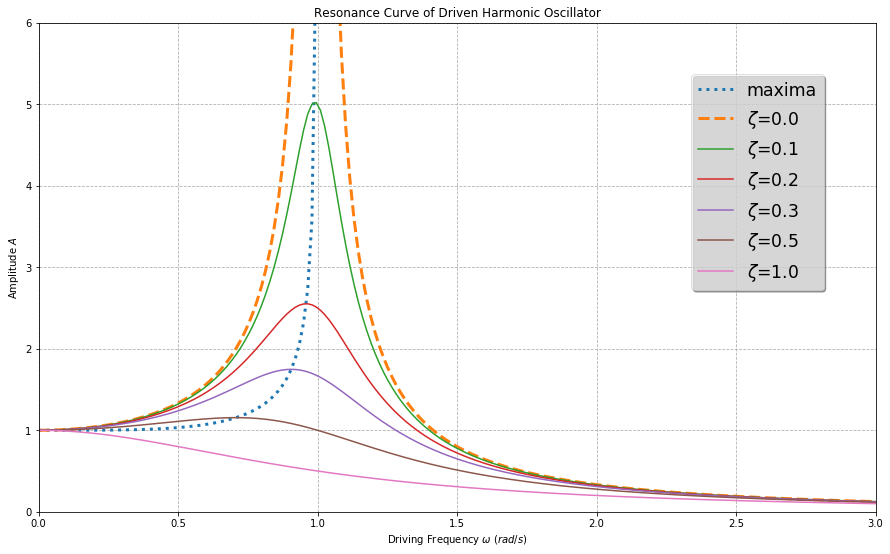

In [8]:
import matplotlib.pyplot as plt

#Graph formatting.
plt.figure(figsize=(15,9))
plt.grid(linestyle='dashed')
plt.xlim(0.0, 3.0)
plt.ylim(0, 6)
plt.title('Resonance Curve of Driven Harmonic Oscillator')
plt.xlabel('Driving Frequency $\omega$ ($rad/s$)')
plt.ylabel('Amplitude $A$')

#Initial conditions and constants of the spring system(s).
stateVector = [0.0, 0.0]
gammaList = [0.1, 0.2, 0.3, 0.5, 1.0]
omegaList = np.linspace(0, 3.0, 200)
fraction = 1e-16

solidStateTime = getSolidStateTime(gammaList, fraction)
# Go from zero to twice the steady state time
timeSteps = np.linspace(0.0, solidStateTime*2.0, 9999)

# Plot maxima curve
maximaCurveY, maximaCurveX = getMaximaCurve(omegaList)
plt.plot(maximaCurveX, maximaCurveY, ':', label = 'maxima', linewidth=3) 

# Plot undamped curve
undampedAmplitudes = getUndampedAmplitudes(omegaList)
plt.plot(omegaList, undampedAmplitudes, '--', label = '$\zeta$=0.0', linewidth=3)

# Gets the list of amplitudes of the function of a given omega and gamma 
for gamma in gammaList:
    
    amplitudes = []
    for omega in omegaList:
        states = integrate.odeint(genHarmonicDampedDriven, stateVector, timeSteps, args=(omega, gamma))
        #Remove first half of list
        states = states[4999:]
        amplitudes.append(findMaxAmplitude(states))
    curve = "$\zeta$=" + str(gamma)
    plt.plot(omegaList, amplitudes, label = curve)   

# Sets legend
legend = plt.legend(loc='upper right', shadow=(True), fontsize='xx-large', borderaxespad=3)
frame = legend.get_frame()
frame.set_facecolor('#f9f9f9')
frame.set_alpha(0.6)

### Concusion
This assignment lived up to the hype, that it would be more difficult to obtain the plot than anticipated. The first hurdle was understanding the concept that numerical integration, coupled with differentiation, would provide a method for which we could approximate the value of a function at later times.

The second, and biggest roadblock, was to determine what exactly was going on with the undamped case. We experimented with plotting the amplitude versus time. Different initial conditions lead to different steady-state solutions. These plots alone did not shed much light on how to obtain the curve in the reference plot. Using the example of a harmonic oscillator under the influence of gravity, we were able to visualize a little better what we were dealing with. This is no doubt essential in computational methods- comparing results with known values is perhaps the only indication we have (at this point in our study) that indicates if our calculations are garbage or valid.

In the end, the use of the theoretical undamped curve produced the plot we were looking for, however it felt like we side-stepped the task at hand. Considering the amount of time invested into this assignment, we eagerly look forward to an explanation in class as to what approach could have been used to determine the undamped curve through the use of numerical integration.